In [2]:
# name generation model
# based on this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read  in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
               # original paper uses a cotext of 3 words
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop first character and append, rolling window

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [8]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [10]:
# embed input in lower dimensional space
# original paper embeds 17,000 words in 30 dimensional space
# we have 27 possible input characters. let's try a 2 dimensional space.
C = torch.randn((27, 2))

In [11]:
C[torch.tensor([5, 6, 7])] # using list or tensor as index instead of number gives us a tensor of the respective values in C

tensor([[ 0.6529, -0.5013],
        [ 0.7260, -1.0445],
        [ 1.2410,  0.3941]])

In [12]:
emb = C[X] # we can also index with multidimensional integers
emb

tensor([[[ 1.0715,  0.6954],
         [ 1.0715,  0.6954],
         [ 1.0715,  0.6954]],

        [[ 1.0715,  0.6954],
         [ 1.0715,  0.6954],
         [ 0.6529, -0.5013]],

        [[ 1.0715,  0.6954],
         [ 0.6529, -0.5013],
         [-1.1747, -0.1716]],

        [[ 0.6529, -0.5013],
         [-1.1747, -0.1716],
         [-1.1747, -0.1716]],

        [[-1.1747, -0.1716],
         [-1.1747, -0.1716],
         [ 0.3782,  0.7977]],

        [[ 1.0715,  0.6954],
         [ 1.0715,  0.6954],
         [ 1.0715,  0.6954]],

        [[ 1.0715,  0.6954],
         [ 1.0715,  0.6954],
         [ 0.2579,  2.1787]],

        [[ 1.0715,  0.6954],
         [ 0.2579,  2.1787],
         [ 2.6669,  0.9808]],

        [[ 0.2579,  2.1787],
         [ 2.6669,  0.9808],
         [ 0.9003, -0.4425]],

        [[ 2.6669,  0.9808],
         [ 0.9003, -0.4425],
         [ 0.8257,  0.4894]],

        [[ 0.9003, -0.4425],
         [ 0.8257,  0.4894],
         [ 0.9003, -0.4425]],

        [[ 0.8257,  0

In [13]:
emb.shape

torch.Size([32, 3, 2])

In [14]:
# hidden layer
W1 = torch.randn((6, 100)) # weights
# 6 x 100 because:
# (number of inputs == 6 == embedding dimensions (2) x n-embeddings per input (3))
#   x 
# (number of neurons in this layer == some arbitrary amount of neurons (100))
b1 = torch.randn(100) # biases

In [15]:
emb @ W1 + b1 # what we want to do

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [ ]:
# but it doesn't work because each element in emb has size (3x2) instead of size 6.
# we need to smush these together somehow.
# there are multiple ways to acheive this depending on exact requirements
# we'll use torch.cat

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)
# this will do it, but it's ugly because it's hard-coded.
# what if we wanted to change the dimensions of emb from e.g. (_, 3, _) to (_, M, _) ?

In [ ]:
# ans: use torch.unbind
#torch.unbind(emb, 1) # == [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]
torch.cat(torch.unbind(emb, 1), 1)
# unfortunately, this is SUPA INEFFICIENT, because torch.cat will copy everything...

In [ ]:
# even BETTER + EFFICIENT ans: use tensor.view!
# changes how tensor is INDEXED instead of STORED. efficient!
# changes storage offset, strides, and shapes
emb.view(32, 6)

In [ ]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
# activations of inputs emb (h for "hidden states")
# could do emb.view(-1, 6) and pytorch would figure out what the first dimension needs to be in order to make the size work
h.shape

In [ ]:
h

In [ ]:
# let's make sure the expression "emb.view(emb.shape[0], 6) @ W1 + b1"
# is broadcasting correctly

In [ ]:
(emb.view(emb.shape[0], 6) @ W1).shape

In [ ]:
b1.shape

In [ ]:
# align on right, make missing dimensions size 1, then copy all dimensions of size 1
# 32 100    32 100    32 100
#    100 ->  1 100 -> 32 100
# so it's correct (note: in case this looks wrong because we know 
#                        matrix multiplication needs (N, M) x (M, O) dimensions,
#                        remember we're not doing a multiplication on these
#                        two values, we're doing an addition, so we actually
#                        do want identical sizes)

In [ ]:
# final layer
W2 = torch.randn((100, 27)) # input size -> 27 characters
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
prob.shape

In [ ]:
prob.sum(1, keepdims=True)

In [ ]:
prob

In [ ]:
# let's look at how likely the neural net thought the actual outputs were
prob[torch.arange(32), Y]

In [ ]:
# that's pretty bad, but it's ok because we haven't trained it at all yet

In [ ]:
torch.arange(32)

In [ ]:
Y

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [ ]:
# ----------------------------------------------------------------
# TIDIED UP! (more respectable)
# ----------------------------------------------------------------

In [ ]:
X.shape, Y.shape # dataset

In [ ]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [ ]:
# ----------------------------------------------------------------
# TIDIED UP, 2! (even MORE respectable)
# ----------------------------------------------------------------

In [ ]:
X.shape, Y.shape # dataset

In [ ]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
emb = C[X] # [32, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss
# andrej explains a bunch of reasons to use F.cross_entropy instead of making your
# own loss function
# 1. efficiency -- pytorch can skip creating intermediate tensors which waste memory
#    and can group operations together or something for more computational
#    efficiency ??
# 2. backward pass is more efficient because F.cross_entropy knows how to do
#    backpropogation better or something ??
# 3. better numerical behaviour -- you skip the bug where calling logits.exp() ends
#    up giving you floating point infinity

In [ ]:
# ----------------------------------------------------------------
# ITERATION 3, MAKE IT ITERATE! (now we're LEARNING with MACHINES)
# ----------------------------------------------------------------

In [ ]:
X.shape, Y.shape # dataset

In [ ]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(10):
    # forward pass
    emb = C[X] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

In [ ]:
# here are the actual highest likelihood predictions
logits.max(1)

In [ ]:
# ----------------------------------------------------------------
# iteration 4 -- FULL DATASET TIME!
# ----------------------------------------------------------------

In [ ]:
block_size = 3 # context length: how many characters do we take to predict the next one?
               # original paper uses a cotext of 3 words
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop first character and append, rolling window

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(1000):   
    # forward pass
    #emb = C[X] # [32, 3, 2]
    # this works but is slow. let's use random subsets of the data to train instead in order to have faster
    # training cycles
    
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # ALSO INDEXING INTO BATCH HERE
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
        


In [ ]:
# example mini batch
torch.randint(0, X.shape[0], (32,))

In [ ]:
# let's check the loss on all the examples
emb = C[X]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss


In [ ]:
# ----------------------------------------------------------------
# iteration 5
# ----------------------------------------------------------------

In [ ]:
# now let's learn how to LEARN a good learning rate

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype

In [ ]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000) # lre -- learning rate exponents
lrs = 10**lre
lrs

In [ ]:
lri = []
lossi = []

for i in range(1000):   

    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass    
    emb = C[X[ix]]
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # ALSO INDEXING INTO BATCH HERE
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track learning rate stats
    lri.append(lre[i])
    lossi.append(loss.item())


In [ ]:
plt.plot(lri, lossi)

In [ ]:
# so 10 ** -1.0 or 0.1 is a pretty good learning rate
# ... why exactly??

In [ ]:
# let's check the loss on all the examples
emb = C[X]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

In [ ]:
# ----------------------------------------------------------------
# iteration 6
# ----------------------------------------------------------------

In [16]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [17]:
for _ in range(1000):   

    #minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # forward pass    
    emb = C[X[ix]]
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix]) # ALSO INDEXING INTO BATCH HERE
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

0.24192525446414948


In [18]:
# after doing a lot of iterations at a certain learning rate, "people like to" do
# what's called learning rate decay, i.e. lowering learning rate e.g. by a factor of 10

In [19]:
# let's check the loss on all the examples
emb = C[X]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(0.3218, grad_fn=<NllLossBackward0>)

In [20]:
# this looks good, because we got a much lower loss (2.28 compared to 2.45 (!))
# however when we use increasingly complex models there becomes a greater danger of overfitting
# therefore we should split the data into multiple batches:
# 1. training split      80% -- to optimize parameters of the model
# 2. dev/validate split  10% -- to optimize hyperparameters (e.g. size of hidden layer, size of embedding, etc.)
# 3. test split          10% -- to evaluate performance at the very end (to avoid overfitting)
# (roughly)

In [21]:
# ----------------------------------------------------------------
# iteration 6 -- TRAIN/TEST SPLIT (OH YEAH, TITLES ARE BACK!)
# ----------------------------------------------------------------

In [22]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
               # original paper uses a cotext of 3 words
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop first character and append, rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype   # new dataset attributes

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [24]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [25]:
for _ in range(10000):   

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item ())

3.031980514526367


In [26]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5639, grad_fn=<NllLossBackward0>)

In [27]:
emb = C[Xtr]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5693, grad_fn=<NllLossBackward0>)

In [28]:
# as we see the dev and training loss are both roughly equal.
# we're not overfitting.
# according to Andrej, we're actually underfitting
# so let's BEEF up those parameters!

In [29]:
C

tensor([[ 0.3855, -0.3094],
        [ 0.1915, -0.3524],
        [ 0.0054, -0.2830],
        [-0.0558, -0.3448],
        [-0.1479, -0.3297],
        [ 0.1020, -0.3132],
        [-0.1356, -0.3468],
        [ 0.4918,  2.3182],
        [-0.1914, -0.2304],
        [-0.0098, -0.3318],
        [-0.2634, -0.3320],
        [-0.1862, -0.3411],
        [ 0.3739,  2.1840],
        [-0.2378, -0.2958],
        [-0.1341, -0.1909],
        [ 0.1308, -0.3527],
        [ 0.3356,  2.0098],
        [-0.3106, -0.5611],
        [-0.2049, -0.3302],
        [-0.0267, -0.4137],
        [-0.1287, -0.4183],
        [ 0.5165,  2.2625],
        [-0.2649, -0.3766],
        [-0.2109, -0.3993],
        [-0.1846, -0.2327],
        [-0.0642, -0.2249],
        [-0.2041, -0.3225]], requires_grad=True)

In [30]:
# ----------------------------------------------------------------
# iteration 6 -- MORE PARAMETERS
# ----------------------------------------------------------------

In [31]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 2), generator=g)
# hidden layer
W1 = torch.randn((6, 300), generator=g) # weights
b1 = torch.randn(300, generator=g) # biases
# output layer (right?)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
# easiest way to increase the size of the nerual net is to increase the size of the hidden layer (27,100) -> (27,300)

In [32]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [33]:
#lri = []
#lossi = []
#stepi = []

for i in range(10000):   

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    #stepi.append(i)
    #lossi.append(loss.item())


#print(loss.item())

In [34]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.5198, grad_fn=<NllLossBackward0>)

In [35]:
emb = C[Xtr]    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5293, grad_fn=<NllLossBackward0>)

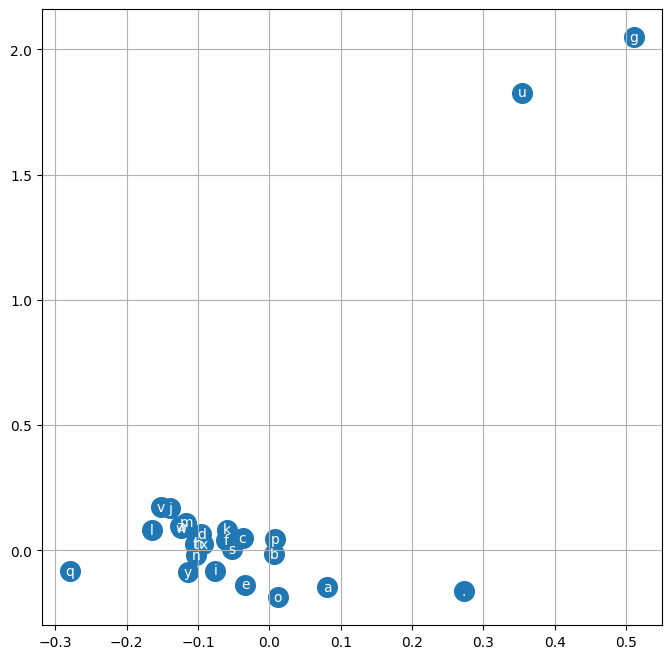

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [37]:
# ----------------------------------------------------------------
# iteration 7 -- MORE (MORE) PARAMETERS
# ----------------------------------------------------------------

In [38]:
# this time we're going to increase the size of the embeddings...
# (and slightly decrease the size of the hidden layer)

g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 10), generator=g)
# hidden layer
W1 = torch.randn((30, 200), generator=g) # weights
b1 = torch.randn(200, generator=g) # biases
# output layer (right?)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [39]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [40]:
#lri = []
#lossi = []
#stepi = []

In [109]:
for i in range(1000):   

    if i % 1000 == 0:
        print(i)
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (256,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    #stepi.append(i)
    #lossi.append(loss.log10().item())


#print(loss.item())

0


In [105]:
#plt.plot(stepi, lossi)

In [110]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1912, grad_fn=<NllLossBackward0>)

In [111]:
emb = C[Xtr]    
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1667, grad_fn=<NllLossBackward0>)

In [45]:
# SAMPLING FROM THE MODEL !!

In [113]:
g = torch.Generator().manual_seed(2 ** 31 - 1 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
mayanniee.
mad.
rylle.
emmancendraek.
adelynnelin.
shy.
jen.
edennestanaraelynn.
houra.
noshibergihimiest.
jair.
jenslen.
pulfzun.
macdariyah.
faeha.
kaysh.
samyah.
hal.
salynn.
juluan.
leouren.
cre.
kaveaisten.
adi.
fen.
oewen.
zorie.
samuey.
con.
reon.
isa.
iri.
evon.
walla.
ortaraszin.
desist.
alingt.
dabilin.
aimellakeyanni.
sxavin.
damariennccayne.
aud.
aiwe.
dah.
virley.
jayerancoo.
grellya.
iimarilon.
ellah.


In [ ]:
# best test loss from the video is 2.1701
# exercise to reader is get a better loss using this model

In [ ]:
# ----------------------------------------------------------------
# iter 8
# ----------------------------------------------------------------

In [119]:
# this time we're going to increase the size of the embeddings...
# (and slightly decrease the size of the hidden layer)

g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 4), generator=g)
# hidden layer
W1 = torch.randn((12, 300), generator=g) # weights
b1 = torch.randn(300, generator=g) # biases
# output layer (right?)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [120]:
sum(p.nelement() for p in parameters) # number of parameters in total

12135

In [149]:
for i in range(50000):   
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (64,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 12) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE

    if i % 1000 == 0:
        print(f'{i}: {loss.item()}')
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    #stepi.append(i)
    #lossi.append(loss.log10().item())


#print(loss.item())

0: 2.115422010421753
1000: 2.2850892543792725
2000: 2.448554515838623
3000: 2.2070627212524414
4000: 2.0405824184417725
5000: 2.063225507736206
6000: 2.068718910217285
7000: 2.4837722778320312
8000: 2.2944014072418213
9000: 2.245450973510742
10000: 2.367769718170166
11000: 2.3223841190338135
12000: 2.012387275695801
13000: 1.904250144958496
14000: 2.2287001609802246
15000: 2.007561206817627
16000: 2.0154168605804443
17000: 2.323148012161255
18000: 2.0671329498291016
19000: 2.1220552921295166
20000: 2.242379665374756
21000: 2.3672664165496826
22000: 2.0212714672088623
23000: 2.203503370285034
24000: 2.4236955642700195
25000: 1.9961293935775757
26000: 2.050748586654663
27000: 2.0382094383239746
28000: 2.001460313796997
29000: 2.073377847671509
30000: 2.3961193561553955
31000: 2.2380309104919434
32000: 2.327364683151245
33000: 2.3748645782470703
34000: 2.3117423057556152
35000: 2.3180580139160156
36000: 2.0150034427642822
37000: 2.0387368202209473
38000: 2.348905086517334
39000: 2.1305565

In [150]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 12) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2189, grad_fn=<NllLossBackward0>)

In [ ]:
# best loss I seem to be able to get is 2.2189

In [151]:
g = torch.Generator().manual_seed(2 ** 31 - 1 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
mayanniee.
med.
ryla.
rethrelengrlee.
aderydaelin.
shyone.
leigh.
estanar.
kayzioh.
kamin.
shubrrgyni.
jest.
jair.
jelionn.
paitoun.
mace.
ryyah.
faeh.
yuve.
myonnyamihalina.
yansun.
zakelveuren.
cre.
kiveaon.
marid.
jahnise.
ban.
prick.
amuez.
con.
reon.
isa.
iri.
evondwhlan.
ortaraszin.
desiah.
alingtelvissivia.
meliaketarriy.
xavin.
damaitenickarionaud.
aive.
dih.
virle.
ajalena.
moiah.
rictaviiah.
glon.
ethayderlon.
jairy.


In [ ]:
# ----------------------------------------------------------------
# iter 8
# ----------------------------------------------------------------

In [152]:
# this time we're going to increase the size of the embeddings...
# (and slightly decrease the size of the hidden layer)

g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 10), generator=g)
# hidden layer
W1 = torch.randn((30, 150), generator=g) # weights
b1 = torch.randn(150, generator=g) # biases
# output layer (right?)
W2 = torch.randn((150, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [153]:
sum(p.nelement() for p in parameters) # number of parameters in total

8997

In [163]:
#lri = []
lossi = []
stepi = []

In [235]:
for i in range(10000):   
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (1000,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE

    if i % 100 == 0:
        print(f'{i}: {loss.item()}')
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


#print(loss.item())

0: 2.1193010807037354
100: 2.1520023345947266
200: 2.204747200012207
300: 2.1593122482299805
400: 2.093663215637207
500: 2.0906312465667725
600: 2.178438663482666
700: 2.159015417098999
800: 2.092186689376831
900: 2.1526906490325928
1000: 2.0854556560516357
1100: 2.232177257537842
1200: 2.12353515625
1300: 2.157930612564087
1400: 2.150251626968384
1500: 2.0945663452148438
1600: 2.084001064300537
1700: 2.0780463218688965
1800: 2.2673988342285156
1900: 2.1284596920013428
2000: 2.131715774536133
2100: 2.130709409713745
2200: 2.135843276977539
2300: 2.095097541809082
2400: 2.136087656021118
2500: 2.1322505474090576
2600: 2.1583902835845947
2700: 2.136890172958374
2800: 2.1116011142730713
2900: 2.1519131660461426
3000: 2.2225863933563232
3100: 2.1293132305145264
3200: 2.215528964996338
3300: 2.1937143802642822
3400: 2.15860652923584
3500: 2.140834331512451
3600: 2.1777970790863037
3700: 2.1546807289123535
3800: 2.159527063369751
3900: 2.184126138687134
4000: 2.0617079734802246
4100: 2.18295

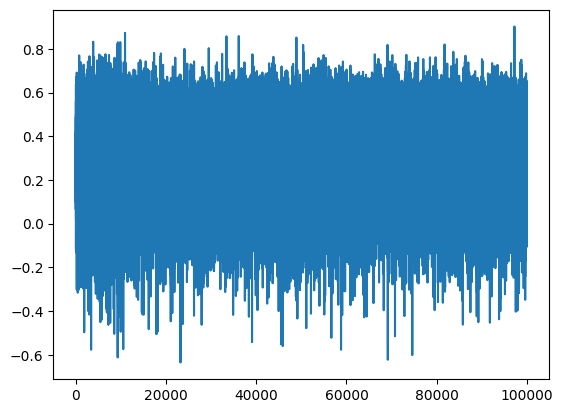

In [236]:
plt.plot(stepi, lossi)

In [237]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1748, grad_fn=<NllLossBackward0>)

In [238]:
emb = C[Xtr]    
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1448, grad_fn=<NllLossBackward0>)

In [ ]:
# best loss is 2.14 ??

In [239]:
g = torch.Generator().manual_seed(2 ** 31 - 1 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
med.
rylla.
emmruttadrlee.
adelynneliah.
milopi.
eden.
estanara.
myki.
hotalin.
sher.
roshiriel.
kinto.
jenslen.
parrius.
kynder.
yadleyel.
yume.
myskeyla.
hal.
salyansuf.
zakhloe.
ren.
crevis.
jaiel.
pordin.
kyloe.
bayziei.
jorettyn.
kharlo.
jian.
iri.
evon.
walla.
ortarashten.
goela.
alitan.
debil.
vid.
mellanetarriy.
xavi.
jakelizenickayionald.
aive.
dihevirley.
jayena.
moialorictamiia.
jolon.
ethayderlina.


In [ ]:
# ----------------------------------------------------------------
# iter 9 -- let's try more context!!
# ----------------------------------------------------------------

In [402]:
block_size = 8 # context length: how many characters do we take to predict the next one?
               # original paper uses a cotext of 3 words

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop first character and append, rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182456, 8]) torch.Size([182456])
torch.Size([22752, 8]) torch.Size([22752])
torch.Size([22938, 8]) torch.Size([22938])


In [403]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 5), generator=g)
# hidden layer
W1 = torch.randn((40, 100), generator=g) # weights
b1 = torch.randn(100, generator=g) # biases
# output layer (right?)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [404]:
sum(p.nelement() for p in parameters) # number of parameters in total

6962

In [436]:
for i in range(10000):   
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (1000,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE

    if i % 100 == 0:
        print(f'{i}: {loss.item()}')
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    #stepi.append(i)
    #lossi.append(loss.log10().item())


#print(loss.item())

0: 2.3255388736724854
100: 2.3185596466064453
200: 2.266429901123047
300: 2.3607137203216553
400: 2.2683298587799072
500: 2.322235584259033
600: 2.295442819595337
700: 2.3104755878448486
800: 2.282677173614502
900: 2.270017385482788
1000: 2.239888906478882
1100: 2.3697705268859863
1200: 2.2212793827056885
1300: 2.32245135307312
1400: 2.3299078941345215
1500: 2.3041253089904785
1600: 2.238553047180176
1700: 2.2814693450927734
1800: 2.338242530822754
1900: 2.2348952293395996
2000: 2.286409854888916
2100: 2.29797101020813
2200: 2.2634520530700684
2300: 2.269585371017456
2400: 2.31355357170105
2500: 2.357513904571533
2600: 2.1928603649139404
2700: 2.2710089683532715
2800: 2.323629140853882
2900: 2.2475507259368896
3000: 2.2773640155792236
3100: 2.2593796253204346
3200: 2.3024513721466064
3300: 2.258265733718872
3400: 2.303119659423828
3500: 2.281431198120117
3600: 2.326287031173706
3700: 2.2870404720306396
3800: 2.338315963745117
3900: 2.33196759223938
4000: 2.252747058868408
4100: 2.25247

In [437]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 40) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3066, grad_fn=<NllLossBackward0>)

In [438]:
g = torch.Generator().manual_seed(2 ** 31 - 1 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mriaalmya.
zieel.
ndhayah.
rethan.
ejdrar.
cadered.
eliileli.
jellene.
sosoraa.
selten.
hokea.
noshdber.
shimies.
kinir.
jelilan.
pucriu.
zeyvde.
kyleli.
ehsylae.
myskeyd.
ahilina.
yansuf.
zalel.
juren.
cutris.
jaoen.
pordin.
kykoe.
bhigpein.
samuey.
chhmreo.
miilani.
jevondwal.
ayleta.
shithne.
sila.
alityn.
dabisin.
dameel.
ketanna.
saavin.
damacienna.
alin.
audtii.
bryah.
vorle.
ajalera.
moialo.
litamii.
karlon.


In [ ]:
# ----------------------------------------------------------------
# iter 10 -- fat hidden layer
# ----------------------------------------------------------------

In [439]:
block_size = 3 # context length: how many characters do we take to predict the next one?
               # original paper uses a cotext of 3 words

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop first character and append, rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182544, 3]) torch.Size([182544])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22862, 3]) torch.Size([22862])


In [440]:
g = torch.Generator().manual_seed(2 ** 31 - 1) # for reproducibility
C = torch.randn((27, 4), generator=g)
# hidden layer
W1 = torch.randn((12, 500), generator=g) # weights
b1 = torch.randn(500, generator=g) # biases
# output layer (right?)
W2 = torch.randn((500, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [441]:
sum(p.nelement() for p in parameters) # number of parameters in total

20135

In [ ]:
for i in range(100000):   
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (100,))

    # forward pass    
    emb = C[Xtr[ix]]
    
    h = torch.tanh(emb.view(-1, 12) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # ALSO INDEXING INTO BATCH HERE

    if i % 1000 == 0:
        print(f'{i}: {loss.item()}')
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    #stepi.append(i)
    #lossi.append(loss.log10().item())


#print(loss.item())

0: 2.400026798248291
1000: 2.516403913497925
2000: 2.4230902194976807
3000: 2.5435056686401367
4000: 2.444976329803467
5000: 2.3983139991760254
6000: 2.4675819873809814
7000: 2.6710329055786133
8000: 2.5114474296569824
9000: 2.3859541416168213
10000: 2.4838268756866455
11000: 2.405278205871582
12000: 2.4701006412506104
13000: 2.357053518295288
14000: 2.462113857269287
15000: 2.3935656547546387
16000: 2.3927245140075684
17000: 2.0862677097320557
18000: 2.405197858810425
19000: 2.271212100982666
20000: 2.304227113723755
21000: 2.3869893550872803
22000: 2.2916066646575928
23000: 2.3300557136535645
24000: 2.214477777481079
25000: 2.469085216522217
26000: 2.3047218322753906
27000: 2.4863810539245605
28000: 2.2919373512268066
29000: 2.328839063644409
30000: 2.399650812149048
31000: 2.2756433486938477
32000: 2.3534815311431885
33000: 2.1997742652893066
34000: 2.411691188812256
35000: 2.489468812942505
36000: 2.2106142044067383
37000: 2.440631151199341
38000: 2.2793445587158203
39000: 2.172184

In [ ]:
emb = C[Xdev]    
h = torch.tanh(emb.view(-1, 12) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
g = torch.Generator().manual_seed(2 ** 31 - 1 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))